# Demand Response in Grid2OP.
Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/Grid2Op/grid2op/master)
                                
**Objectives**

In the previous notebooks, we presented actions in a discrete action space. However, more actions are available in Grid2Op. Redispatching and curtailment are kind of continuous action that will be described here.

This notebook will:

- [I) Redispatching](#redispatching) details redispatching
    - present what redispatching is
    - show how it can be used in grid2op
    - detail the redispatching actions
    - show an example of a redispatching Agent
- [II) Curtailment](#curtailment) explains the curtailment
    - show the behaviour of the curtailment: how to perform it, what is does etc.
    - expose some limits of this curtailment: it can break the grid easily !


Execute the cell below by removing the # character if you use google colab !

<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">

Cell will look like:
```python
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)
```


In [1]:
# !pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)

In [2]:
import grid2op
from grid2op.Agent import DoNothingAgent, BaseAgent
from tqdm.notebook import tqdm  # for easy progress bar
from pathlib import Path
display_tqdm = False  # this is set to False for ease with the unitt test, feel free to set it to True
import numpy as np
max_iter = 100  # to make computation much faster we will only consider 100 time steps
import matplotlib.pyplot as plt

c:\Users\Deuce\Documents\projects\Grid2Op\venv_grid2op\Lib\site-packages\numba\core\config.py:168: UserWarning: CUDA Python bindings requested (the environment variable NUMBA_CUDA_USE_NVIDIA_BINDING is set), but they are not importable: No module named 'cuda'.
  warnings.warn(msg)


By default, some environments do not specify the cost of generators, their maximum and minimum production values, etc. In this case it is not possible to redispatch in grid2op.

To know more about what is needed for using redispatching, it is advised to look at this help online : https://grid2op.readthedocs.io/en/latest/space.html#grid2op.Space.GridObjects.redispatching_unit_commitment_availble for the most recent documentation. When this notebook was created, the following were needed:

- "load_size" : the maximum value a load can consume
- "load_flexible": whether this load is capable of providing demand response 
- "load_max_ramp_up": the maximum increase of power a generator can have between two consecutive time steps
- "load_max_ramp_down": the maximum decrease of power a generator can have between two consecutive time steps
- "load_cost_per_MW": the cost of activating 1MW of demand response. 

We made available a dedicated environment, based on the IEEE case5 powergrid that has all this features. It is advised to use this small environment for testing and getting familiar with demand response.

In [3]:
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend

env_name = "rte_case5_flexibility"
env = grid2op.make(env_name, test=True, backend=bk_cls())

print(f"Is this environment suitable for redispatching: {env.redispatching_unit_commitment_availble}")
print(f"Is this environment suitable for flexibility: {env.flexibility_is_available}")

c:\Users\Deuce\Documents\projects\Grid2Op\grid2op\MakeEnv\Make.py:453: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Is this environment suitable for redispatching: True
Is this environment suitable for flexibility: True


c:\Users\Deuce\Documents\projects\Grid2Op\venv_grid2op\Lib\site-packages\lightsim2grid\gridmodel\from_pandapower\_aux_add_slack.py:114: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


In [4]:
env.load_size

array([10.7,  9.7, 10. ], dtype=float32)

In [5]:
act = env.action_space({"flexibility": [(0, +1)]})
act.is_ambiguous()

(True,
 Grid2OpException AmbiguousAction InvalidFlexibility InvalidFlexibility('Trying to apply a flexibility action on a non-flexible load'))

This action will:
	 - NOT change anything to the injections
	 - Modify the generators with redispatching in the following way:
	 	 - Redispatch "gen_1_1" of 2.00 MW
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
	 - NOT perform any flexibility action


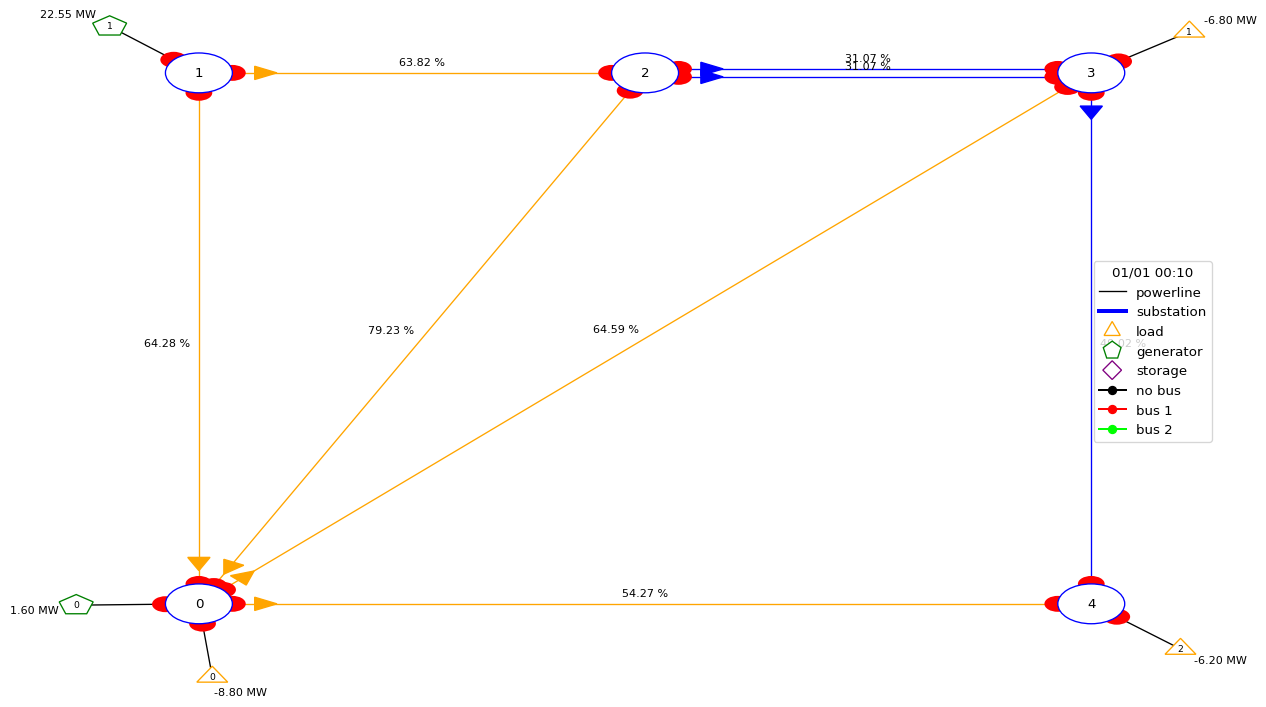

Target Dispatch: [0.         0.00029647]
Actual Dispatch: [0.         0.00029655]
Target Flex: [0. 0. 0.]
Actual Flex: [ 0.        -1.1950618 -1.7995671]
Total Load: 21.81 :: Total Gen: 24.15 :: Losses 2.21


In [ ]:
import matplotlib.pyplot as plt
from grid2op.PlotGrid import PlotMatplot
act = env.action_space({# "flexibility": [(1, +1)],
                        "redispatch": [(1, 2)]})
env.set_id(0)  # make sure to use the same environment input data.
obs_init = env.reset()
plotter = PlotMatplot(env.observation_space)
print(act)
obs, reward, done, info = env.step(act)
plotter.plot_obs(obs)
plt.show()
print(f"Target Dispatch: {obs.target_dispatch}")
print(f"Actual Dispatch: {obs.actual_dispatch}")
print(f"Target Flex: {obs.target_flex}")
print(f"Actual Flex: {obs.actual_flex}")
print(f"Total Load: {obs.load_p.sum():.2f} :: Total Gen: {obs.gen_p.sum():.2f} :: Losses {np.abs(np.abs(obs.p_or)-np.abs(obs.p_ex)).sum():.2f}")